In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from buffer import MultiModelActivationBuffer

from datasets import load_dataset
import torch as t
from dataclasses import dataclass

from nnsight import LanguageModel
from buffer import MultiModelActivationBuffer
from trainers.top_k import TopKTrainer, AutoEncoderTopK
from training import trainSAE
from einops import rearrange, einsum, repeat
import matplotlib.pyplot as plt
from tqdm import tqdm
from trainers.top_k import AutoEncoderTopK
device = "cuda:0"
dtype = t.bfloat16

In [2]:

ae = AutoEncoderTopK.from_hf(f"jacobcd52/pythia70m_step143000_sae", device=device)

layer = 4
out_batch_size = 8192

model_list = []
submodule_list = []

for step in [143000]: #tqdm([0, 128, 256, 512, 1000, 2000, 4000, 8000, 16000, 32000, 64000, 143000]):
    model = LanguageModel(
        "EleutherAI/pythia-70m", 
        revision=f"step{step}", 
        trust_remote_code=False, 
        device_map=device,
        torch_dtype=dtype,
        dispatch=True
        )
    for x in model.parameters():
        x.requires_grad = False

    model_list.append(model)
    submodule_list.append(model.gpt_neox.layers[layer])
    
activation_dim = 512

dataset = load_dataset(
    'Skylion007/openwebtext', 
    split='train', 
    streaming=True,
    trust_remote_code=True
    )

dataset = dataset.shuffle(42)

class CustomData():
    def __init__(self, dataset):
        self.data = iter(dataset)

    def __iter__(self):
        return self

    def __next__(self):
        return next(self.data)['text']

data = CustomData(dataset)

buffer = MultiModelActivationBuffer(
    data=CustomData(dataset),
    model_list=model_list,
    submodule_list=submodule_list,
    d_submodule=activation_dim,
    n_ctxs=1024, 
    device=device,
    refresh_batch_size=512,
    out_batch_size=out_batch_size,
    remove_bos=True,
    rescale_acts=True,
    n_init_batches=1
)

buffer.act_mean[-1] = ae.act_mean
buffer.act_cov_inv_sqrt[-1] = ae.act_cov_inv_sqrt

/root/pretraining_diffing/notebooks/../trainers/top_k.py:144: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = t.load(path)


Computing statistics for rescaling activations...

Batch 1/1
Total samples so far: 65024

Computing final statistics...
Statistics computed.


In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import pickle
import os
from dataclasses import dataclass, field
from einops import rearrange

# Configuration as a dataclass
@dataclass
class Config:
    # Training parameters
    learning_rate: float = 1e-3
    num_epochs: int = 5
    val_split: float = 0.2
    
    # Class weight parameter for addressing imbalance
    pos_weight: float = 10.0  # Weight for positive class examples
    
    # Data collection
    num_data_iterations: int = 100  # How many times to collect data
    
    # Paths
    data_dir: str = "collected_data/"
    save_dir: str = "index_probes/"
    
    # Device
    device: torch.device = field(default_factory=lambda: torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    
    # Model parameters (to be set during runtime)
    n_models: int = None  # Number of models (previously number of steps)
    n_indices: int = None  # Will be set from ae.encoder.weight.shape[0]
    k_indices: int = None  # Will be set from ae.k
    batch_size: int = None  # Will be set from buffer output shape

    # Evals
    feature_chunk_size: int = 1000  # Number of features to process in each chunk   


# Replace Focal Loss with a simple weighted BCE loss
class WeightedBCEWithLogitsLoss(nn.Module):
    def __init__(self, pos_weight=10.0, reduction='mean'):
        super(WeightedBCEWithLogitsLoss, self).__init__()
        self.pos_weight = pos_weight
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        # Create a weight tensor that's 1.0 for negative class and pos_weight for positive class
        weights = torch.ones_like(targets)
        weights[targets > 0] = self.pos_weight
        
        # Apply weighted BCE loss
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(
            inputs, targets, weight=weights, reduction=self.reduction
        )
        
        return BCE_loss


# Vectorized logistic classifier for all indices
class VectorizedIndexProbe(nn.Module):
    def __init__(self, input_dim, num_indices):
        super(VectorizedIndexProbe, self).__init__()
        self.linear = nn.Linear(input_dim, num_indices)
        
    def forward(self, x):
        # Convert input to same dtype as model weights to avoid dtype mismatches
        if x.dtype != self.linear.weight.dtype:
            x = x.to(self.linear.weight.dtype)
        return self.linear(x)


# Prepare targets from indices
def prepare_targets(inds, n_indices):
    """
    Convert indices tensor to binary targets for each possible index
    
    Args:
        inds: Tensor of shape [batch, k] containing indices present
        n_indices: Total number of possible indices
        
    Returns:
        targets: Binary tensor of shape [batch, n_indices]
    """
    batch_size, k = inds.shape
    targets = torch.zeros(batch_size, n_indices, dtype=torch.float32, device=inds.device)
    
    # For each batch, set the indices present to 1
    for b in range(batch_size):
        targets[b, inds[b]] = 1.0
    
    return targets


# Stage 1: Collect data and save to disk
def collect_and_save_data(buffer, ae, config, iterations=None, chunk_size=10000):
    """
    Collect data from buffer and save to disk in chunks
    
    Args:
        buffer: Buffer that returns concatenated tensors
        ae: Autoencoder model used to get indices
        config: Configuration object
        iterations: Number of iterations to collect data (if None, use config value)
        chunk_size: Maximum number of samples to save in each chunk
        
    Returns:
        data_info: Dictionary with information about saved data
    """
    # Create data directory if it doesn't exist
    os.makedirs(config.data_dir, exist_ok=True)
    
    # Set n_indices and k_indices from the autoencoder model
    config.n_indices = ae.encoder.weight.shape[0]  # N
    config.k_indices = ae.k  # k
    print(f"Determined n_indices={config.n_indices}, k_indices={config.k_indices} from model")
    
    # Use config.num_data_iterations if iterations is None
    if iterations is None:
        iterations = config.num_data_iterations
    
    print(f"Collecting data for {iterations} iterations with chunk size {chunk_size}...")
    
    # Determine the dimension from the autoencoder
    d = ae.encoder.weight.shape[1]
    
    # Keep track of total samples and chunks
    total_samples = 0
    chunk_count = 0
    
    # Lists to store data for current chunk
    chunk_x = []
    chunk_inds = []
    
    # Lists to store chunk information
    x_chunks = []
    inds_chunks = []
    targets_chunks = []
    
    # Collect data
    for i in tqdm(range(iterations)):
        # Get concatenated data from buffer
        x_concat = next(buffer)
        
        # Determine batch size from first iteration if not already set
        if config.batch_size is None:
            config.batch_size = x_concat.shape[0]
            print(f"Determined batch_size={config.batch_size} from buffer output")
        
        # Rearrange to get separate model outputs
        # Determine n_models if not already set
        if config.n_models is None:
            config.n_models = x_concat.shape[1] // d
            print(f"Determined n_models={config.n_models} from buffer output")
        
        x = rearrange(x_concat, '... (n d) -> ... n d', n=config.n_models, d=d)
        
        # Get indices from the last model
        _, _, inds, _ = ae.encode(x[:, -1], return_topk=True)
        
        # Store data
        chunk_x.append(x.detach().cpu())
        chunk_inds.append(inds.detach().cpu())
        
        # Update total samples
        batch_size = x.shape[0]
        total_samples += batch_size
        
        # Check if we should save this chunk
        if total_samples >= chunk_size:
            # Concatenate data for this chunk
            x_data = torch.cat(chunk_x, dim=0)
            inds_data = torch.cat(chunk_inds, dim=0)
            
            # Convert to float32 for consistency
            if x_data.dtype != torch.float32:
                x_data = x_data.to(torch.float32)
            
            # Prepare targets from indices
            targets_data = prepare_targets(inds_data, config.n_indices)
            
            # Save chunk to disk
            x_path = os.path.join(config.data_dir, f"x_data_chunk{chunk_count}.pt")
            inds_path = os.path.join(config.data_dir, f"indices_chunk{chunk_count}.pt")
            targets_path = os.path.join(config.data_dir, f"targets_chunk{chunk_count}.pt")
            
            torch.save(x_data, x_path)
            torch.save(inds_data, inds_path)
            torch.save(targets_data, targets_path)
            
            # Store chunk paths
            x_chunks.append(x_path)
            inds_chunks.append(inds_path)
            targets_chunks.append(targets_path)
            
            # Reset for next chunk
            chunk_x = []
            chunk_inds = []
            total_samples = 0
            chunk_count += 1
    
    # Save any remaining data as a final chunk
    if chunk_x:
        # Concatenate remaining data
        x_data = torch.cat(chunk_x, dim=0)
        inds_data = torch.cat(chunk_inds, dim=0)
        
        # Convert to float32 for consistency
        if x_data.dtype != torch.float32:
            x_data = x_data.to(torch.float32)
        
        # Prepare targets from indices
        targets_data = prepare_targets(inds_data, config.n_indices)
        
        # Save final chunk to disk
        x_path = os.path.join(config.data_dir, f"x_data_chunk{chunk_count}.pt")
        inds_path = os.path.join(config.data_dir, f"indices_chunk{chunk_count}.pt")
        targets_path = os.path.join(config.data_dir, f"targets_chunk{chunk_count}.pt")
        
        torch.save(x_data, x_path)
        torch.save(inds_data, inds_path)
        torch.save(targets_data, targets_path)
        
        # Store chunk paths
        x_chunks.append(x_path)
        inds_chunks.append(inds_path)
        targets_chunks.append(targets_path)
    
    # Save config and chunk information
    data_info = {
        "n_models": config.n_models,
        "n_indices": config.n_indices,
        "k_indices": config.k_indices,
        "batch_size": config.batch_size,
        "total_chunks": chunk_count + 1,
        "x_chunks": x_chunks,
        "indices_chunks": inds_chunks,
        "targets_chunks": targets_chunks
    }
    
    # Save data info to disk
    info_path = os.path.join(config.data_dir, "data_info.pkl")
    with open(info_path, "wb") as f:
        pickle.dump(data_info, f)
    
    print(f"Data collection complete. Total chunks: {chunk_count + 1}")
    
    # Return data info
    return data_info


# Stage 2: Train probes using collected data
def train_probes_from_saved_data(config, data_info=None):
    """
    Train probes using data loaded from disk
    
    Args:
        config: Configuration object
        data_info: Dictionary with information about saved data (if None, load from default path)
        
    Returns:
        results: Dictionary with probe results
    """
    # Create save directory if it doesn't exist
    os.makedirs(config.save_dir, exist_ok=True)
    
    # Load data info if not provided
    if data_info is None:
        info_path = os.path.join(config.data_dir, "data_info.pkl")
        with open(info_path, "rb") as f:
            data_info = pickle.load(f)
    
    # Update config with data info
    config.n_models = data_info["n_models"]
    config.n_indices = data_info["n_indices"]
    config.k_indices = data_info["k_indices"]
    config.batch_size = data_info["batch_size"]
    
    print(f"Loaded config: n_models={config.n_models}, n_indices={config.n_indices}, k_indices={config.k_indices}")
    print(f"Training with {data_info['total_chunks']} chunks of data")
    
    # Results will be stored here
    results = {}
    
    # Train a probe for each model
    for model_idx in range(config.n_models):
        print(f"Training probe for model {model_idx}/{config.n_models-1}...")
        
        # Train the vectorized probe for this model using all chunks
        probe, auroc_scores, class_accuracies = train_model_probe_from_chunks(
            model_idx, 
            data_info["x_chunks"], 
            data_info["targets_chunks"],
            config
        )
        
        # Store results
        results[model_idx] = {
            'probe': probe,
            'auroc': auroc_scores,
            'class_accuracies': class_accuracies
        }
        
        # Calculate and print summary statistics
        avg_auroc = np.mean(auroc_scores)
        avg_pos_acc = np.nanmean(class_accuracies['positive'])
        avg_neg_acc = np.nanmean(class_accuracies['negative'])
        avg_balanced_acc = np.nanmean(class_accuracies['balanced'])
        
        print(f"Model {model_idx} - Summary Statistics:")
        print(f"  Average AUROC: {avg_auroc:.4f}")
        print(f"  Average Positive Class Accuracy: {avg_pos_acc:.4f}")
        print(f"  Average Negative Class Accuracy: {avg_neg_acc:.4f}")
        print(f"  Average Balanced Accuracy: {avg_balanced_acc:.4f}")
        
        # Save probe
        torch.save(probe.state_dict(), f"{config.save_dir}/vectorized_probe_model{model_idx}.pt")
        
        # Save metrics
        np.save(f"{config.save_dir}/auroc_model{model_idx}.npy", auroc_scores)
        np.save(f"{config.save_dir}/pos_acc_model{model_idx}.npy", class_accuracies['positive'])
        np.save(f"{config.save_dir}/neg_acc_model{model_idx}.npy", class_accuracies['negative'])
        np.save(f"{config.save_dir}/balanced_acc_model{model_idx}.npy", class_accuracies['balanced'])
    
    # Save overall results
    with open(f"{config.save_dir}/results_summary.pkl", "wb") as f:
        pickle.dump({
            model_idx: {
                'auroc': results[model_idx]['auroc'],
                'pos_acc': results[model_idx]['class_accuracies']['positive'],
                'neg_acc': results[model_idx]['class_accuracies']['negative'],
                'balanced_acc': results[model_idx]['class_accuracies']['balanced']
            } for model_idx in results
        }, f)
    
    return results

def train_model_probe_from_chunks(model_idx, x_chunk_paths, targets_chunk_paths, config):
    """
    Train a probe for a specific model using chunked data
    
    Args:
        model_idx: Index of the model to train probe for
        x_chunk_paths: List of paths to x data chunks
        targets_chunk_paths: List of paths to targets data chunks
        config: Configuration object
        
    Returns:
        probe: Trained probe model
        auroc_scores: AUROC scores for each index
        class_accuracies: Dictionary with per-class accuracies
        valid_indices: Boolean mask indicating which indices have enough positive examples
    """
    # Import torcheval for AUROC calculation
    from torcheval.metrics import BinaryAUROC
    
    # Initialize the model
    d = ae.encoder.weight.shape[1]  # Get dimension from the autoencoder
    probe = VectorizedIndexProbe(d, config.n_indices).to(config.device)
    
    # Initialize optimizer and loss
    optimizer = optim.Adam(probe.parameters(), lr=config.learning_rate)
    criterion = WeightedBCEWithLogitsLoss(pos_weight=config.pos_weight)
    
    # Set aside one chunk for validation (don't use the last chunk, use a random one)
    num_chunks = len(x_chunk_paths)
    if num_chunks > 1:
        # Use a random chunk for validation, but not the last one which might be incomplete
        val_chunk_idx = np.random.randint(0, num_chunks - 1)
    else:
        # If only one chunk, use part of it for validation
        val_chunk_idx = None
    
    # Create training chunk indices (exclude validation chunk)
    train_chunk_indices = [i for i in range(num_chunks) if i != val_chunk_idx]
    
    print(f"Using chunk {val_chunk_idx} for validation, {len(train_chunk_indices)} chunks for training")
    
    # Training loop - process chunks sequentially
    for epoch in range(config.num_epochs):
        probe.train()
        epoch_loss = 0.0
        total_batches = 0
        
        print(f"Epoch {epoch+1}/{config.num_epochs} - Processing {len(train_chunk_indices)} training chunks")
        
        # Iterate through training chunks
        for chunk_idx in train_chunk_indices:
            # Load chunk data with weights_only=True
            x_data = torch.load(x_chunk_paths[chunk_idx], weights_only=True)
            targets_data = torch.load(targets_chunk_paths[chunk_idx], weights_only=True)
            
            # Extract features for this model
            x_model = x_data[:, model_idx]
            
            # Create data loader for this chunk
            chunk_dataset = TensorDataset(x_model, targets_data)
            chunk_loader = DataLoader(chunk_dataset, batch_size=config.batch_size, shuffle=True)
            
            # Train on this chunk
            chunk_loss = 0.0
            for batch_x, batch_targets in chunk_loader:
                batch_x = batch_x.to(config.device)
                batch_targets = batch_targets.to(config.device)
                
                # Ensure data types match
                if batch_x.dtype != torch.float32:
                    batch_x = batch_x.to(torch.float32)
                if batch_targets.dtype != torch.float32:
                    batch_targets = batch_targets.to(torch.float32)
                
                # Forward pass
                outputs = probe(batch_x)
                loss = criterion(outputs, batch_targets)
                
                # Backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                chunk_loss += loss.item()
                total_batches += 1
            
            # Report chunk progress
            avg_chunk_loss = chunk_loss / len(chunk_loader)
            epoch_loss += chunk_loss
            print(f"  Chunk {chunk_idx}/{len(train_chunk_indices)-1}, Loss: {avg_chunk_loss:.4f}")
        
        # Report epoch results
        avg_epoch_loss = epoch_loss / total_batches
        print(f"Epoch {epoch+1}/{config.num_epochs}, Avg Loss: {avg_epoch_loss:.4f}")
    
    # Evaluate on validation set
    probe.eval()
    
    # If we have a validation chunk, use it
    if val_chunk_idx is not None:
        # Load validation data with weights_only=True
        x_val_data = torch.load(x_chunk_paths[val_chunk_idx], weights_only=True)
        targets_val_data = torch.load(targets_chunk_paths[val_chunk_idx], weights_only=True)
    else:
        # Otherwise split the last chunk for validation
        x_data = torch.load(x_chunk_paths[0], weights_only=True)
        targets_data = torch.load(targets_chunk_paths[0], weights_only=True)
        n_samples = x_data.shape[0]
        n_val = int(n_samples * config.val_split)
        
        # Split the data
        indices = torch.randperm(n_samples)
        val_indices = indices[:n_val]
        
        x_val_data = x_data[val_indices]
        targets_val_data = targets_data[val_indices]
    
    # Extract features for this model
    x_val_model = x_val_data[:, model_idx]
    
    # Create data loader for validation with a smaller batch size to reduce memory usage
    # Using a smaller batch size during evaluation to prevent memory issues
    eval_batch_size = min(1024, config.batch_size)  # Limit batch size during evaluation
    val_dataset = TensorDataset(x_val_model, targets_val_data)
    val_loader = DataLoader(val_dataset, batch_size=eval_batch_size, shuffle=False)
    
    # Identify indices with at least 10 positive examples in the validation set
    # We do this BEFORE processing the whole validation set to save memory
    pos_counts = torch.zeros(config.n_indices)
    
    # Count positives in batches to avoid loading all data at once
    for _, batch_targets in val_loader:
        pos_counts += torch.sum(batch_targets, dim=0)
    
    # Identify valid indices (at least 10 positive examples)
    valid_indices = pos_counts >= 10
    valid_proportion = torch.mean(valid_indices.float()).item()
    valid_indices_list = torch.where(valid_indices)[0].tolist()
    
    print(f"\nProportion of indices with ≥10 positive examples in validation set: {valid_proportion:.4f} ({len(valid_indices_list)}/{config.n_indices})")
    
    # Initialize AUROC scores tensor with default value 0.5
    auroc_scores = np.ones(config.n_indices) * -1
    
    # Only compute metrics for valid indices to save memory
    if valid_indices_list:
        # Process valid indices in chunks to balance memory usage and efficiency
        
        for chunk_start in range(0, len(valid_indices_list), config.feature_chunk_size):
            chunk_end = min(chunk_start + config.feature_chunk_size, len(valid_indices_list))
            chunk_indices = valid_indices_list[chunk_start:chunk_end]
            
            print(f"Processing AUROC for features {chunk_start} to {chunk_end-1} of {len(valid_indices_list)} valid features")
            
            # Initialize metrics for this chunk of features
            chunk_metrics = [BinaryAUROC() for _ in range(len(chunk_indices))]
            
            # Process each batch
            for batch_x, batch_targets in val_loader:
                batch_x = batch_x.to(config.device)
                
                # Forward pass through the model once per batch
                with torch.no_grad():
                    if batch_x.dtype != torch.float32:
                        batch_x = batch_x.to(torch.float32)
                    outputs = probe(batch_x)
                    
                    # Process each feature in this chunk
                    for i, idx in enumerate(chunk_indices):
                        # Apply sigmoid to get probabilities
                        probs = torch.sigmoid(outputs[:, idx]).cpu()
                        targets = batch_targets[:, idx].int()
                        
                        # Update metric with this batch
                        chunk_metrics[i].update(probs.squeeze(), targets.squeeze())
            
            # Compute final AUROC for each feature in this chunk
            for i, idx in enumerate(chunk_indices):
                try:
                    auroc_scores[idx] = chunk_metrics[i].compute().item()
                except Exception as e:
                    print(f"Warning: Could not compute AUROC for index {idx}: {e}")
    
    # Calculate per-class accuracies (with memory optimization)
    pos_acc = np.zeros(config.n_indices)
    neg_acc = np.zeros(config.n_indices)
    balanced_acc = np.zeros(config.n_indices)
    
    # Initialize counters for each index
    true_pos = np.zeros(config.n_indices)
    false_pos = np.zeros(config.n_indices)
    true_neg = np.zeros(config.n_indices)
    false_neg = np.zeros(config.n_indices)
    
    # Process in batches
    for batch_x, batch_targets in val_loader:
        batch_x = batch_x.to(config.device)
        
        # Forward pass
        with torch.no_grad():
            if batch_x.dtype != torch.float32:
                batch_x = batch_x.to(torch.float32)
            outputs = probe(batch_x)
            preds = (torch.sigmoid(outputs) > 0.5).float().cpu()
            
            # Update counters
            batch_targets = batch_targets.cpu()
            for idx in valid_indices_list:
                # Get predictions and targets for this index
                idx_preds = preds[:, idx].numpy()
                idx_targets = batch_targets[:, idx].numpy()
                
                # Update confusion matrix
                true_pos[idx] += np.sum((idx_preds == 1) & (idx_targets == 1))
                false_pos[idx] += np.sum((idx_preds == 1) & (idx_targets == 0))
                true_neg[idx] += np.sum((idx_preds == 0) & (idx_targets == 0))
                false_neg[idx] += np.sum((idx_preds == 0) & (idx_targets == 1))
    
    # Calculate accuracies
    for idx in valid_indices_list:
        if (true_pos[idx] + false_neg[idx]) > 0:
            pos_acc[idx] = true_pos[idx] / (true_pos[idx] + false_neg[idx])
        else:
            pos_acc[idx] = np.nan
            
        if (true_neg[idx] + false_pos[idx]) > 0:
            neg_acc[idx] = true_neg[idx] / (true_neg[idx] + false_pos[idx])
        else:
            neg_acc[idx] = np.nan
            
        # Calculate balanced accuracy
        valid_accs = []
        if not np.isnan(pos_acc[idx]):
            valid_accs.append(pos_acc[idx])
        if not np.isnan(neg_acc[idx]):
            valid_accs.append(neg_acc[idx])
        
        balanced_acc[idx] = np.mean(valid_accs) if valid_accs else np.nan
    
    # Store results
    class_accuracies = {
        'positive': pos_acc,
        'negative': neg_acc,
        'balanced': balanced_acc,
        'valid_indices': valid_indices.cpu().numpy()
    }
    
    # Report some examples of per-class accuracy
    print("\nClass accuracy examples (selected indices):")
    for idx in range(min(5, config.n_indices)):  # Show first 5 indices
        pos_count = pos_counts[idx].item()
        valid_status = "valid" if pos_count >= 10 else "invalid"
        print(f"  Index {idx}: Positive acc = {pos_acc[idx]:.4f}, Negative acc = {neg_acc[idx]:.4f}, " 
              f"Balanced acc = {balanced_acc[idx]:.4f}, Positive count = {pos_count} ({valid_status})")
    
    return probe, auroc_scores, class_accuracies

# Function to calculate class-specific accuracies
def calculate_class_accuracies(probe, x, targets, config, threshold=0.5):
    """
    Calculate separate accuracies for positive and negative classes
    
    Args:
        probe: Trained probe model
        x: Input tensor
        targets: Target tensor
        config: Configuration
        threshold: Decision threshold for binary classification
        
    Returns:
        pos_accuracies: Accuracy for positive class (true positives / all positives)
        neg_accuracies: Accuracy for negative class (true negatives / all negatives)
        balanced_accuracies: Average of positive and negative accuracies
    """
    probe.eval()
    x = x.to(config.device)
    targets = targets.to(config.device)
    
    # Ensure data types match
    if x.dtype != torch.float32:
        x = x.to(torch.float32)
    
    # Get predictions
    with torch.no_grad():
        logits = probe(x)
        preds = (torch.sigmoid(logits) > threshold).float()
    
    # Calculate accuracies for each index
    pos_accuracies = np.zeros(config.n_indices)
    neg_accuracies = np.zeros(config.n_indices)
    balanced_accuracies = np.zeros(config.n_indices)
    
    for idx in range(config.n_indices):
        # Get predictions and targets for this index
        idx_preds = preds[:, idx].cpu().numpy()
        idx_targets = targets[:, idx].cpu().numpy()
        
        # Positive samples (where target is 1)
        pos_mask = (idx_targets == 1)
        if np.any(pos_mask):
            pos_accuracies[idx] = np.mean(idx_preds[pos_mask] == idx_targets[pos_mask])
        else:
            pos_accuracies[idx] = np.nan
        
        # Negative samples (where target is 0)
        neg_mask = (idx_targets == 0)
        if np.any(neg_mask):
            neg_accuracies[idx] = np.mean(idx_preds[neg_mask] == idx_targets[neg_mask])
        else:
            neg_accuracies[idx] = np.nan
        
        # Balanced accuracy (average of positive and negative accuracies)
        valid_accs = []
        if not np.isnan(pos_accuracies[idx]):
            valid_accs.append(pos_accuracies[idx])
        if not np.isnan(neg_accuracies[idx]):
            valid_accs.append(neg_accuracies[idx])
        
        balanced_accuracies[idx] = np.mean(valid_accs) if valid_accs else np.nan
    
    return pos_accuracies, neg_accuracies, balanced_accuracies


def evaluate_probes(results, config):
    """
    Analyze and report on probe performance
    
    Args:
        results: Dictionary with probe results for each model
        config: Configuration object
        
    Returns:
        analysis: Dictionary with analysis results
    """
    analysis = {}
    
    for model_idx, model_results in results.items():
        auroc_scores = model_results['auroc']
        class_accuracies = model_results['class_accuracies']
        valid_indices = class_accuracies['valid_indices']
        
        # Calculate statistics for AUROC - only for valid indices
        valid_aurocs = auroc_scores[valid_indices]
        mean_auroc = np.mean(valid_aurocs)
        median_auroc = np.median(valid_aurocs)
        min_auroc = np.min(valid_aurocs)
        max_auroc = np.max(valid_aurocs)
        
        # Find top and bottom performing indices among valid ones
        valid_indices_list = np.where(valid_indices)[0]
        top_valid_indices = valid_indices_list[np.argsort(valid_aurocs)[::-1][:10]]
        bottom_valid_indices = valid_indices_list[np.argsort(valid_aurocs)[:10]]
        
        print(f"\nModel {model_idx} Analysis:")
        print(f"Proportion of indices with ≥10 positive examples: {np.mean(valid_indices):.4f} ({np.sum(valid_indices)}/{len(valid_indices)})")
        print(f"Mean AUROC (valid indices): {mean_auroc:.4f}")
        print(f"Median AUROC (valid indices): {median_auroc:.4f}")
        print(f"Min AUROC (valid indices): {min_auroc:.4f}")
        print(f"Max AUROC (valid indices): {max_auroc:.4f}")
        
        # Calculate statistics for class accuracies - only for valid indices
        pos_acc = class_accuracies['positive'][valid_indices]
        neg_acc = class_accuracies['negative'][valid_indices]
        balanced_acc = class_accuracies['balanced'][valid_indices]
        
        print(f"Mean Positive Accuracy (valid indices): {np.nanmean(pos_acc):.4f}")
        print(f"Mean Negative Accuracy (valid indices): {np.nanmean(neg_acc):.4f}")
        print(f"Mean Balanced Accuracy (valid indices): {np.nanmean(balanced_acc):.4f}")
        
        print(f"\nTop 10 valid indices by AUROC:")
        for i, idx in enumerate(top_valid_indices):
            print(f"  {i+1}. Index {idx}: AUROC = {auroc_scores[idx]:.4f}, " 
                  f"Pos Acc = {class_accuracies['positive'][idx]:.4f}, Neg Acc = {class_accuracies['negative'][idx]:.4f}")
        
        print(f"\nBottom 10 valid indices by AUROC:")
        for i, idx in enumerate(bottom_valid_indices):
            print(f"  {i+1}. Index {idx}: AUROC = {auroc_scores[idx]:.4f}, "
                  f"Pos Acc = {class_accuracies['positive'][idx]:.4f}, Neg Acc = {class_accuracies['negative'][idx]:.4f}")
        
        # Store analysis
        analysis[model_idx] = {
            'mean_auroc': mean_auroc,
            'median_auroc': median_auroc,
            'min_auroc': min_auroc,
            'max_auroc': max_auroc,
            'top_indices': top_valid_indices.tolist(),
            'bottom_indices': bottom_valid_indices.tolist(),
            'mean_pos_acc': np.nanmean(pos_acc),
            'mean_neg_acc': np.nanmean(neg_acc),
            'mean_balanced_acc': np.nanmean(balanced_acc),
            'valid_proportion': np.mean(valid_indices),
            'valid_count': np.sum(valid_indices)
        }
    
    # Save analysis results
    analysis_path = os.path.join(config.save_dir, "analysis_results.pkl")
    with open(analysis_path, "wb") as f:
        pickle.dump(analysis, f)
    
    return analysis


# Usage example
"""
# Initialize buffer and autoencoder
buffer = ...  # Your buffer that returns concatenated tensors
ae = ...  # Your autoencoder model

# Create configuration
config = Config()

# Stage 1: Collect and save data
data_info = collect_and_save_data(buffer, ae, config, chunk_size=10000)

# Stage 2: Train probes using saved data
results = train_probes_from_saved_data(config, data_info)

# Analyze results
analysis = evaluate_probes(results, config)
"""

'\n# Initialize buffer and autoencoder\nbuffer = ...  # Your buffer that returns concatenated tensors\nae = ...  # Your autoencoder model\n\n# Create configuration\nconfig = Config()\n\n# Stage 1: Collect and save data\ndata_info = collect_and_save_data(buffer, ae, config, chunk_size=10000)\n\n# Stage 2: Train probes using saved data\nresults = train_probes_from_saved_data(config, data_info)\n\n# Analyze results\nanalysis = evaluate_probes(results, config)\n'

In [27]:
config = Config(
    learning_rate=1e-1,
    num_epochs=1,
    val_split=0.2,
    pos_weight=10.0,
    num_data_iterations=200,
    data_dir="collected_data/",
    save_dir="index_probes/",
    device=device,
    batch_size=32768,
    feature_chunk_size=1000
)

In [28]:
path = collect_and_save_data(buffer, ae, config, chunk_size=32768)

Determined n_indices=8192, k_indices=128 from model


  0%|          | 0/200 [00:00<?, ?it/s]

Determined n_models=1 from buffer output


100%|██████████| 200/200 [01:58<00:00,  1.69it/s]

Data collection complete. Total chunks: 51


In [38]:
results = train_probes_from_saved_data(config, path)

Loaded config: n_models=1, n_indices=8192, k_indices=128
Training with 51 chunks of data
Training probe for model 0/0...
Using chunk 26 for validation, 49 chunks for training
Epoch 1/1 - Processing 49 training chunks
  Chunk 0/48, Loss: 0.8367
  Chunk 1/48, Loss: 0.9236
  Chunk 2/48, Loss: 0.8152
  Chunk 3/48, Loss: 0.6937
  Chunk 4/48, Loss: 0.6807
  Chunk 5/48, Loss: 0.6398
  Chunk 6/48, Loss: 0.5937
  Chunk 7/48, Loss: 0.5296
  Chunk 8/48, Loss: 0.4903
  Chunk 9/48, Loss: 0.4681
  Chunk 10/48, Loss: 0.4488
  Chunk 11/48, Loss: 0.4275
  Chunk 12/48, Loss: 0.3913
  Chunk 13/48, Loss: 0.3677
  Chunk 14/48, Loss: 0.3379
  Chunk 15/48, Loss: 0.3175
  Chunk 16/48, Loss: 0.3012
  Chunk 17/48, Loss: 0.2855
  Chunk 18/48, Loss: 0.2732
  Chunk 19/48, Loss: 0.2553
  Chunk 20/48, Loss: 0.2413
  Chunk 21/48, Loss: 0.2274
  Chunk 22/48, Loss: 0.2187
  Chunk 23/48, Loss: 0.2077
  Chunk 24/48, Loss: 0.1988
  Chunk 25/48, Loss: 0.1898
  Chunk 27/48, Loss: 0.1814
  Chunk 28/48, Loss: 0.1739
  Chunk 2

avg auroc 0.9828203137399287


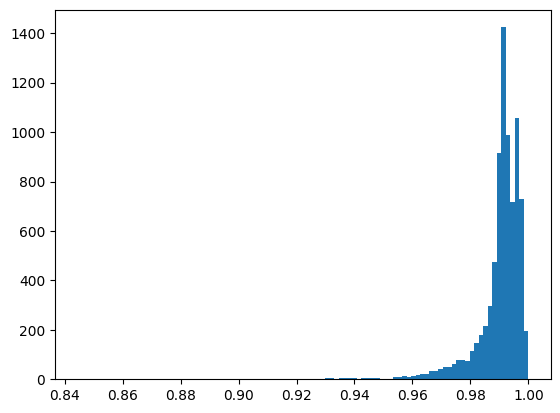

In [39]:
aurocs = results[0]['auroc']
good_aurocs = aurocs[aurocs > -1]
print("avg auroc", aurocs.mean())
plt.hist(good_aurocs, bins=100)
plt.show()